## Cross-validating C5.0 using Steinmetz data

In [239]:
# Dependencies
library(tidyverse)
library(C50)
library(mice)
library(partykit)
library(caret)
library(pROC)
library(data.table)
library(gridExtra)

In [240]:
# Loading training and testing data. Label is also cast into factor datatype and testing data is scaled
data_train <- read.csv('~/Desktop/data_transformed_train.csv')[,-1]%>% 
             mutate(Go_Trial = as.factor(Go_Trial)) 
data_test <- read.csv('~/Desktop/data_transformed_test.csv')[,-1] %>% 
             mutate(Go_Trial = as.factor(Go_Trial)) 
data_test <- data_test %>% mutate_at(colnames(data_test %>% select(-Go_Trial)),~ scale(., center = F))

In [243]:
# Simulate missing values using MCAR with probability of 0.1 and save to CSV
set.seed(123)
data_train_mcar <- ampute(data_train %>% select(-Go_Trial), prop = 0.1, mech = "MCAR")$amp %>% mutate(Go_Trial = data_train$Go_Trial)
summary(data_train_mcar)
#write.csv(data_train_mcar, '~/Desktop/data_transformed_train_mcar.csv')

    X0_Wheel        X1_Wheel         X2_Wheel         X3_Wheel     
 Min.   : 0.00   Min.   : 0.000   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:12.72   1st Qu.: 8.097   1st Qu.: 9.421   1st Qu.: 8.065  
 Median :14.24   Median : 9.173   Median :14.082   Median :12.604  
 Mean   :13.86   Mean   : 9.179   Mean   :11.879   Mean   :10.539  
 3rd Qu.:15.75   3rd Qu.:10.617   3rd Qu.:14.665   3rd Qu.:13.179  
 Max.   :16.30   Max.   :11.444   Max.   :15.146   Max.   :13.667  
 NA's   :35      NA's   :31       NA's   :36       NA's   :32      
    X0_Face          X1_Face          X2_Face          X3_Face      
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.3168   1st Qu.:0.2461   1st Qu.:0.2923   1st Qu.:0.3636  
 Median :0.4332   Median :0.3574   Median :0.4039   Median :0.4709  
 Mean   :0.6820   Mean   :0.5836   Mean   :0.6433   Mean   :0.7058  
 3rd Qu.:0.9859   3rd Qu.:0.8309   3rd Qu.:0.9213   3rd Qu.:0.9837  
 Max.   :2.6358   Max.   :2.5089   Max.   

In [244]:
# Loading training set with missing values CSV
data_train_mcar <- read.csv('~/Desktop/data_transformed_train_mcar.csv')[,-1]%>% 
             mutate(Go_Trial = as.factor(Go_Trial))
summary(data_train_mcar)

    X0_Wheel        X1_Wheel         X2_Wheel         X3_Wheel     
 Min.   : 0.00   Min.   : 0.000   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:12.72   1st Qu.: 8.097   1st Qu.: 9.421   1st Qu.: 8.065  
 Median :14.24   Median : 9.173   Median :14.082   Median :12.604  
 Mean   :13.86   Mean   : 9.179   Mean   :11.879   Mean   :10.539  
 3rd Qu.:15.75   3rd Qu.:10.617   3rd Qu.:14.665   3rd Qu.:13.179  
 Max.   :16.30   Max.   :11.444   Max.   :15.146   Max.   :13.667  
 NA's   :35      NA's   :31       NA's   :36       NA's   :32      
    X0_Face          X1_Face          X2_Face          X3_Face      
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.3168   1st Qu.:0.2461   1st Qu.:0.2923   1st Qu.:0.3636  
 Median :0.4332   Median :0.3574   Median :0.4039   Median :0.4709  
 Mean   :0.6820   Mean   :0.5836   Mean   :0.6433   Mean   :0.7058  
 3rd Qu.:0.9859   3rd Qu.:0.8309   3rd Qu.:0.9213   3rd Qu.:0.9837  
 Max.   :2.6358   Max.   :2.5089   Max.   

In [245]:
# Predictors used as well as label (Go_Trial)
colnames(data_train)

[1] "X0_Wheel"        "X1_Wheel"        "X2_Wheel"        "X3_Wheel"       
 [5] "X0_Face"         "X1_Face"         "X2_Face"         "X3_Face"        
 [9] "X0_Pupil_Area"   "X1_Pupil_Area"   "X2_Pupil_Area"   "X3_Pupil_Area"  
[13] "X0_Pupil_Xcoord" "X1_Pupil_Xcoord" "X2_Pupil_Xcoord" "X3_Pupil_Xcoord"
[17] "X0_Pupil_Ycoord" "X1_Pupil_Ycoord" "X2_Pupil_Ycoord" "X3_Pupil_Ycoord"
[21] "Go_Trial"

In [302]:
#' Instantiate an empty dataframe filled with NAs to save results for each value of n_Trials on training, validation, and testing
#' 
#' @param n_Trials A numeric vector.
#' @return A dataframe of dimension (length(n_Trials)x6).
create_results_df <- function(n_Trials = c(20, 40, 60, 80)){
    df <-  data.frame(matrix(NA, nrow = length(n_Trials), ncol = 6), row.names = n_Trials)
    colnames(df) <- c('Training_mean', 'Training_sd', 'Validation_mean', 'Validation_sd', 'Testing_mean', 'Testing_sd')
    return(df)
}

#' Split a dataset df into k folds
#' 
#' @param df A dataframe.
#' @param k An integer.
#' @param seed An integer, optional.
#' @return A list of dataframes of length k.
k_split <- function(df,k, seed = 1){
    set.seed(seed)
    grp <- rep(1:k, length.out = nrow(df))
    df |>
      mutate(grp = sample(grp, nrow(df), replace = F)) |>
      group_split(grp)|>
      map(\(d) select(d, -grp))
  }

#' Calculate precision from confusion matrix as TP/(TP + FP)
#' 
#' @param confusion_matrix A matrix of dimension 2x2.
#' @return A numeric value in the range [0,1], NA if TP = FP = 0.
calc_precision <- function(confusion_matrix){
    if(confusion_matrix[2,2] == 0 & confusion_matrix[2,1] == 0){
        return(NA)
    }
    return(confusion_matrix[2,2]/(confusion_matrix[2,2] + confusion_matrix[2,1]))
}

#' Calculate recall from confusion matrix as TP/(TP + FN)
#' 
#' @param confusion_matrix A matrix of dimension 2x2.
#' @return A numeric value in the range [0,1], NA if TP = FN = 0.
calc_recall <- function(confusion_matrix){
    if(confusion_matrix[2,2] == 0 & confusion_matrix[1,2] == 0){
        return(NA)
    }
    return(confusion_matrix[2,2]/(confusion_matrix[2,2] + confusion_matrix[1,2]))
}

#' Calculate specificity from confusion matrix as TN/(TN + FP)
#' 
#' @param confusion_matrix A matrix of dimension 2x2.
#' @return A numeric value in the range [0,1], NA if TN = FP = 0.
calc_specificity <- function(confusion_matrix){
    if(confusion_matrix[1,1] == 0 & confusion_matrix[2,1] == 0){
        return(NA)
    }
    return(confusion_matrix[1,1]/(confusion_matrix[1,1] + confusion_matrix[2,1]))
}

#' Calculate AUC score from model prediction ROC curve
#' 
#' @param pred A numeric vector of model predicitions.
#' @param true A numeric vector of ground truths.
#' @param quiet A boolean indicating if process should be silent, optional (default is FALSE).
#' @return A numeric value in the range [0,1].
calc_auc <- function(pred, true, quiet = FALSE){
    return(auc(roc(true, pred, quiet = quiet)))
}

#' Calculate F1-score from model precision and recall
#' 
#' @param precision A numeric value.
#' @param recall A numeric value.
#' @return A numeric value in the range [0,1], NA if precision = recall = NA (although TP = FN = FP = 0 is unlikely).
calc_f1 <- function(precision, recall){
    if(is.na(precision) & is.na(recall)){
        return(NA)
    }
    return(2*(precision * recall)/(precision + recall))
}

#' Perform k-fold cross validation using C5.0 with an option to tune number of boosting trials without early stopping
#' 
#' @param data_train A numeric dataframe for training.
#' @param data_test A numeric dataframe for testing.
#' @param ycol An integer indicating index of ground truth column, optional (default is 21).
#' @param window_sizes A numeric vector with values for 'trials' to try, optional (default is c(20, 40, 60, 80)).
#' @param k_folds An integer indicating number of CV folds, optional (default is 10).
#' @param n_iter An integer indicating number of times to repeat experiment, optional (default is 30).
#' @param start_seed An integer indicating the starting seed for each value in window_sizes, optional (default is 123).
#' @return A list of results including:
#'        trees being a dataframe of dimension of n_iter*k x length(window_sizes), 
#'        a dataframe of dimension length(window_sizes)x6 for each precision, recall, specificity, accuracy, AUC, and F1, 
#'        confusion_matrices being a list of length 3 with each element being a list of length n_iter*k,
#'        n_Trials in a numeric vector,
#'        best containing an integer being the best value from window_sizes,
#'        rulesets being a list of length 3 with each element being a list of length n_iter*k,
#'        ruleset_sizes being a dataframe of dimension of n_iter*k x length(window_sizes),
#'        predictor_usage being a dataframe of dimension of length(window_sizes) x (ncol(data_train)-1)
cross_validate_C50 <- function(data_train, 
                               data_test,
                               ycol = 21, 
                               window_sizes = c(20, 40, 60, 80), 
                               k_folds = 10, 
                               n_iter = 30, 
                               start_seed = 123){
    trees_w <- list()
    rulesets_w <- list()
    ruleset_sizes_w <- list()
    predictor_usage <- data.frame(matrix(0, nrow = length(window_sizes), ncol = ncol(data_train) - 1))
    colnames(predictor_usage) <- colnames(data_train[,-ycol])

    confusion_matrices_w <- list()
    precision_agg <- create_results_df(window_sizes)
    recall_agg <- create_results_df(window_sizes)
    specificity_agg <- create_results_df(window_sizes)
    auc_agg <- create_results_df(window_sizes)
    f1_agg <- create_results_df(window_sizes)
    acc_agg <- create_results_df(window_sizes)

    for(w in window_sizes){
        print("=======================================================================================")
        print("=======================================================================================")
        print(paste("Trials:", w))
        print("=======================================================================================")
        print("=======================================================================================")

        trees <- list()
        rulesets <- list()
        ruleset_sizes <- c()
        idw <- which(window_sizes == w)
        confusion_matrices <- list()
        precision <- data.frame(matrix(NA, nrow = k_folds*n_iter, ncol = 3))
        recall <- data.frame(matrix(NA, nrow = k_folds*n_iter, ncol = 3))
        specificity <- data.frame(matrix(NA, nrow = k_folds*n_iter, ncol = 3))
        auc <- data.frame(matrix(NA, nrow = k_folds*n_iter, ncol = 3))
        f1 <- data.frame(matrix(NA, nrow = k_folds*n_iter, ncol = 3))
        acc <- data.frame(matrix(NA, nrow = k_folds*n_iter, ncol = 3))
        
        count <- 0
        for(i in 1:n_iter){
            print("================================================================")
            print(paste("Iteration:", i))
            print("================================================================")

            kf <- k_split(data_train, k = k_folds, seed = start_seed + i - 1)

            for(k in 1:k_folds){
              print("----------------------------")  
              print(paste("Fold:", k))
              print("----------------------------")

              count <- count + 1
              
              # split data to validation and training and scale each
              scaled_split_val <- as.data.frame(kf[[k]]) %>% 
                           mutate_at(colnames(data_train[,-ycol]),~ scale(., center = F))
              scaled_split_tr <- as.data.frame(bind_rows(kf[-k])) %>% 
                           mutate_at(colnames(data_train[,-ycol]),~ scale(., center = F))
              
              tree <- C5.0(as.formula(paste(colnames(scaled_split_tr)[ycol], " ~ .")), data = scaled_split_tr, trials = w, control = C5.0Control(earlyStopping = FALSE, seed = start_seed + i))
              ruleset <- partykit:::.list.rules.party(C50:::as.party.C5.0(tree))
              trees[[count]] <- tree
              rulesets[[count]] <- ruleset
              ruleset_sizes <- c(ruleset_sizes, unname(sapply(ruleset, FUN = str_count, '&') + 1))
              predictor_usage[idw,] <- predictor_usage[idw,] + (data.frame(t(sapply(ruleset, FUN = str_count, colnames(data_train[,-ycol])))) %>% summarize_all(sum))

              pred_tr <- predict(tree, newdata = scaled_split_tr[,-ycol])
              pred_val <- predict(tree, newdata = scaled_split_val[,-ycol])
              pred_te <- predict(tree, newdata = data_test[,-ycol])

              confusion_matrices[['train']][[count]] <- confusionMatrix(scaled_split_tr[,ycol], pred_tr)$table
              confusion_matrices[['val']][[count]] <- confusionMatrix(scaled_split_val[,ycol], pred_val)$table
              confusion_matrices[['test']][[count]] <- confusionMatrix(data_test[,ycol], pred_te)$table
                
              precision[count, 1] <- calc_precision(confusion_matrices[['train']][[count]])
              precision[count, 2] <- calc_precision(confusion_matrices[['val']][[count]])
              precision[count, 3] <- calc_precision(confusion_matrices[['test']][[count]])

              recall[count, 1] <- calc_recall(confusion_matrices[['train']][[count]])
              recall[count, 2] <- calc_recall(confusion_matrices[['val']][[count]])
              recall[count, 3] <- calc_recall(confusion_matrices[['test']][[count]])

              specificity[count, 1] <- calc_specificity(confusion_matrices[['train']][[count]])
              specificity[count, 2] <- calc_specificity(confusion_matrices[['val']][[count]])
              specificity[count, 3] <- calc_specificity(confusion_matrices[['test']][[count]])

              auc[count, 1] <- calc_auc(predict(tree, newdata = scaled_split_tr[,-ycol], type = 'prob')[,2], scaled_split_tr[,ycol])
              auc[count, 2] <- calc_auc(predict(tree, newdata = scaled_split_val[,-ycol], type = 'prob')[,2], scaled_split_val[,ycol])
              auc[count, 3] <- calc_auc(predict(tree, newdata = data_test[,-ycol], type = 'prob')[,2], data_test[,ycol])

              f1[count, 1] <- calc_f1(precision[count, 1], recall[count, 1])
              f1[count, 2] <- calc_f1(precision[count, 2], recall[count, 2])
              f1[count, 3] <- calc_f1(precision[count, 3], recall[count, 3])

              acc[count, 1] <- mean(pred_tr == scaled_split_tr[,ycol])
              acc[count, 2] <- mean(pred_val == scaled_split_val[,ycol])
              acc[count, 3] <- mean(pred_te == data_test[,ycol])
            }
        }
        trees_w[[as.character(w)]] <- trees
        rulesets_w[[as.character(w)]] <- rulesets
        ruleset_sizes_w[[as.character(w)]] <- ruleset_sizes
        confusion_matrices_w[[as.character(w)]] <- confusion_matrices
        
        #' Aggregate metric results as mean and SD for each of n_Trials values and the 3 sets of instances while ignoring NAs
        #' 
        #' @param res A numeric dataframe of dimension n_iter*k x 3.
        #' @return A numeric dataframe of dimension 1x6
        agg <- function(res){
            return(res %>% summarize(across(everything(), list(mean = ~mean(.,na.rm = TRUE), sd = ~sd(.,na.rm = TRUE)))))
        }
        
        rownames(predictor_usage) <- window_sizes
        precision_agg[idw,] <- agg(precision)
        recall_agg[idw,] <- agg(recall) 
        specificity_agg[idw,] <- agg(specificity)
        auc_agg[idw,] <- agg(auc)
        f1_agg[idw,] <- agg(f1)
        acc_agg[idw,] <- agg(acc)
    }
    return(list(trees = as.data.frame(do.call(cbind, trees_w)), 
                rulesets = rulesets_w, 
                ruleset_sizes = as.data.frame(do.call(cbind, ruleset_sizes_w)), 
                predictor_usage = predictor_usage,
                confusion_matrices = confusion_matrices_w,
                precision = precision_agg, 
                recall = recall_agg, 
                specificity = specificity_agg, 
                auc = auc_agg, 
                f1 = f1_agg,
                acc = acc_agg,
                n_Trials = window_sizes,
                best = window_sizes[which(acc_agg[,5] == max(acc_agg[,5]))]))
}    

#' Plot metric results as mean and SD for each of n_Trials values and the 3 sets of instances as line plots as well as ruleset sizes and predictor usage as a boxplot and bargraph respectively
#' 
#' @param res A numeric dataframe of dimension length(res$window_sizes) x 3.
#' @return None
plot_metrics <- function(res){
    
    
    #' Format df to be of long format and compatible with plotting functions
    #' 
    #' @param df A numeric dataframe of dimension length(res$window_sizes) x 3.
    #' @return A numeric dataframe of dimension length(res$window_sizes)*3 x 4.
    format_df <- function(df, sfx = "_mean"){
        window_sizes <- rownames(df)
        res_m <- df %>% select(ends_with(sfx)) %>% mutate(n_Trials = window_sizes)
        colnames(res_m) <- gsub(sfx, "", colnames(res_m))
        return(res_m %>% pivot_longer(cols = colnames(res_m)[-c(ncol(res_m))], names_to = 'Set', values_to = gsub("_", "", sfx)))
    }
    
    #' plot a single metric line plot with errorbars, grouped by set
    #' 
    #' @param metric_results A numeric dataframe of dimension length(res$window_sizes)*3 x 4.
    #' @param title A string to be used as plot title.
    #' @return A ggplot
    plot_metric <- function(metric_results, title){
        df <- format_df(metric_results) %>% mutate(sd = format_df(metric_results, "_sd")$sd)
        options(repr.plot.width = 20, repr.plot.height = 20)
        ggplot(df, aes(x = n_Trials, y = mean, group = Set, col = Set)) +
        geom_line(aes(linetype = Set), size = 1) +
        geom_point(aes(shape = Set), size = 4) +
        geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), width = 0.2, position = position_dodge(0.05)) +
        ggtitle(title) +
        theme_bw() +
        theme(text = element_text(size = 20))
    }
    
    pr <- plot_metric(res$precision, "Precision")
    sp <- plot_metric(res$specificity, "Specificity")
    rc <- plot_metric(res$recall, "Recall")
    acc <- plot_metric(res$acc, "Accuracy")
    auc <- plot_metric(res$auc, "AUC")
    f1 <- plot_metric(res$f1, "F1-Score")
    
    rs_szs <- ggplot(res$ruleset_sizes %>% pivot_longer(cols = colnames(res$ruleset_sizes), names_to = 'n_Trials', values_to = 'Ruleset_size')) +
        geom_boxplot(aes(x = n_Trials, y = Ruleset_size)) +
        ggtitle('Ruleset sizes by number of boosting trials') +
        theme_bw()
    
    prd_cnt <- ggplot(res$predictor_usage %>% rownames_to_column('n_Trials') %>% pivot_longer(cols = colnames(res$predictor_usage), names_to = 'Predictor', values_to = 'N_Occurance'), aes(x = N_Occurance, y = reorder(Predictor, N_Occurance))) +
        geom_col(aes(fill = n_Trials)) +
        ggtitle('Predictor number of occurances filled by number of boosting trials') +
        theme_bw()
    
    grid.arrange(pr, sp, rc, acc, auc, f1, rs_szs, prd_cnt, ncol = 3, nrow = 3)
}

In [276]:
# 10-fold CV for 30 iterations using the MCAR dataset to tune n_Trials
start_seed <- 123
n_Trials <- c(20, 40, 60, 80)
k_folds <- 10
n_iter <- 30

res_mcar <- cross_validate_C50(data_train = data_train_mcar,
                         data_test = data_test,
                         ycol = 21,
                         window_sizes = n_Trials,
                         k_folds = k_folds,
                         n_iter = n_iter,
                         start_seed = start_seed)

[1] "======================================================================================="
[1] "======================================================================================="
[1] "Trials: 20"
[1] "======================================================================================="
[1] "======================================================================================="
[1] "================================================================"
[1] "Iteration: 1"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 2"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 3"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 4"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 5"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 6"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 7"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 8"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 9"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 10"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 11"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 12"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 13"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 14"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 15"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 16"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 17"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 18"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 19"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 20"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 21"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 22"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 23"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 24"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 25"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 26"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 27"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 28"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 29"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 30"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "======================================================================================="
[1] "======================================================================================="
[1] "Trials: 40"
[1] "======================================================================================="
[1] "======================================================================================="
[1] "================================================================"
[1] "Iteration: 1"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 2"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 3"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 4"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 5"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 6"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 7"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 8"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 9"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 10"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 11"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 12"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 13"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 14"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 15"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 16"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 17"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 18"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 19"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 20"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 21"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 22"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 23"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 24"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 25"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 26"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 27"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 28"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 29"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 30"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "======================================================================================="
[1] "======================================================================================="
[1] "Trials: 60"
[1] "======================================================================================="
[1] "======================================================================================="
[1] "================================================================"
[1] "Iteration: 1"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 2"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 3"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 4"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 5"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 6"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 7"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 8"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 9"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 10"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 11"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 12"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 13"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 14"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 15"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 16"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 17"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 18"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 19"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 20"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 21"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 22"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 23"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 24"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 25"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 26"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 27"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 28"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 29"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 30"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "======================================================================================="
[1] "======================================================================================="
[1] "Trials: 80"
[1] "======================================================================================="
[1] "======================================================================================="
[1] "================================================================"
[1] "Iteration: 1"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 2"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 3"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 4"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 5"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 6"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 7"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 8"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 9"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 10"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 11"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 12"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 13"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 14"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 15"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 16"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 17"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 18"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 19"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 20"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 21"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 22"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 23"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 24"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 25"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 26"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 27"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 28"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 29"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 30"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



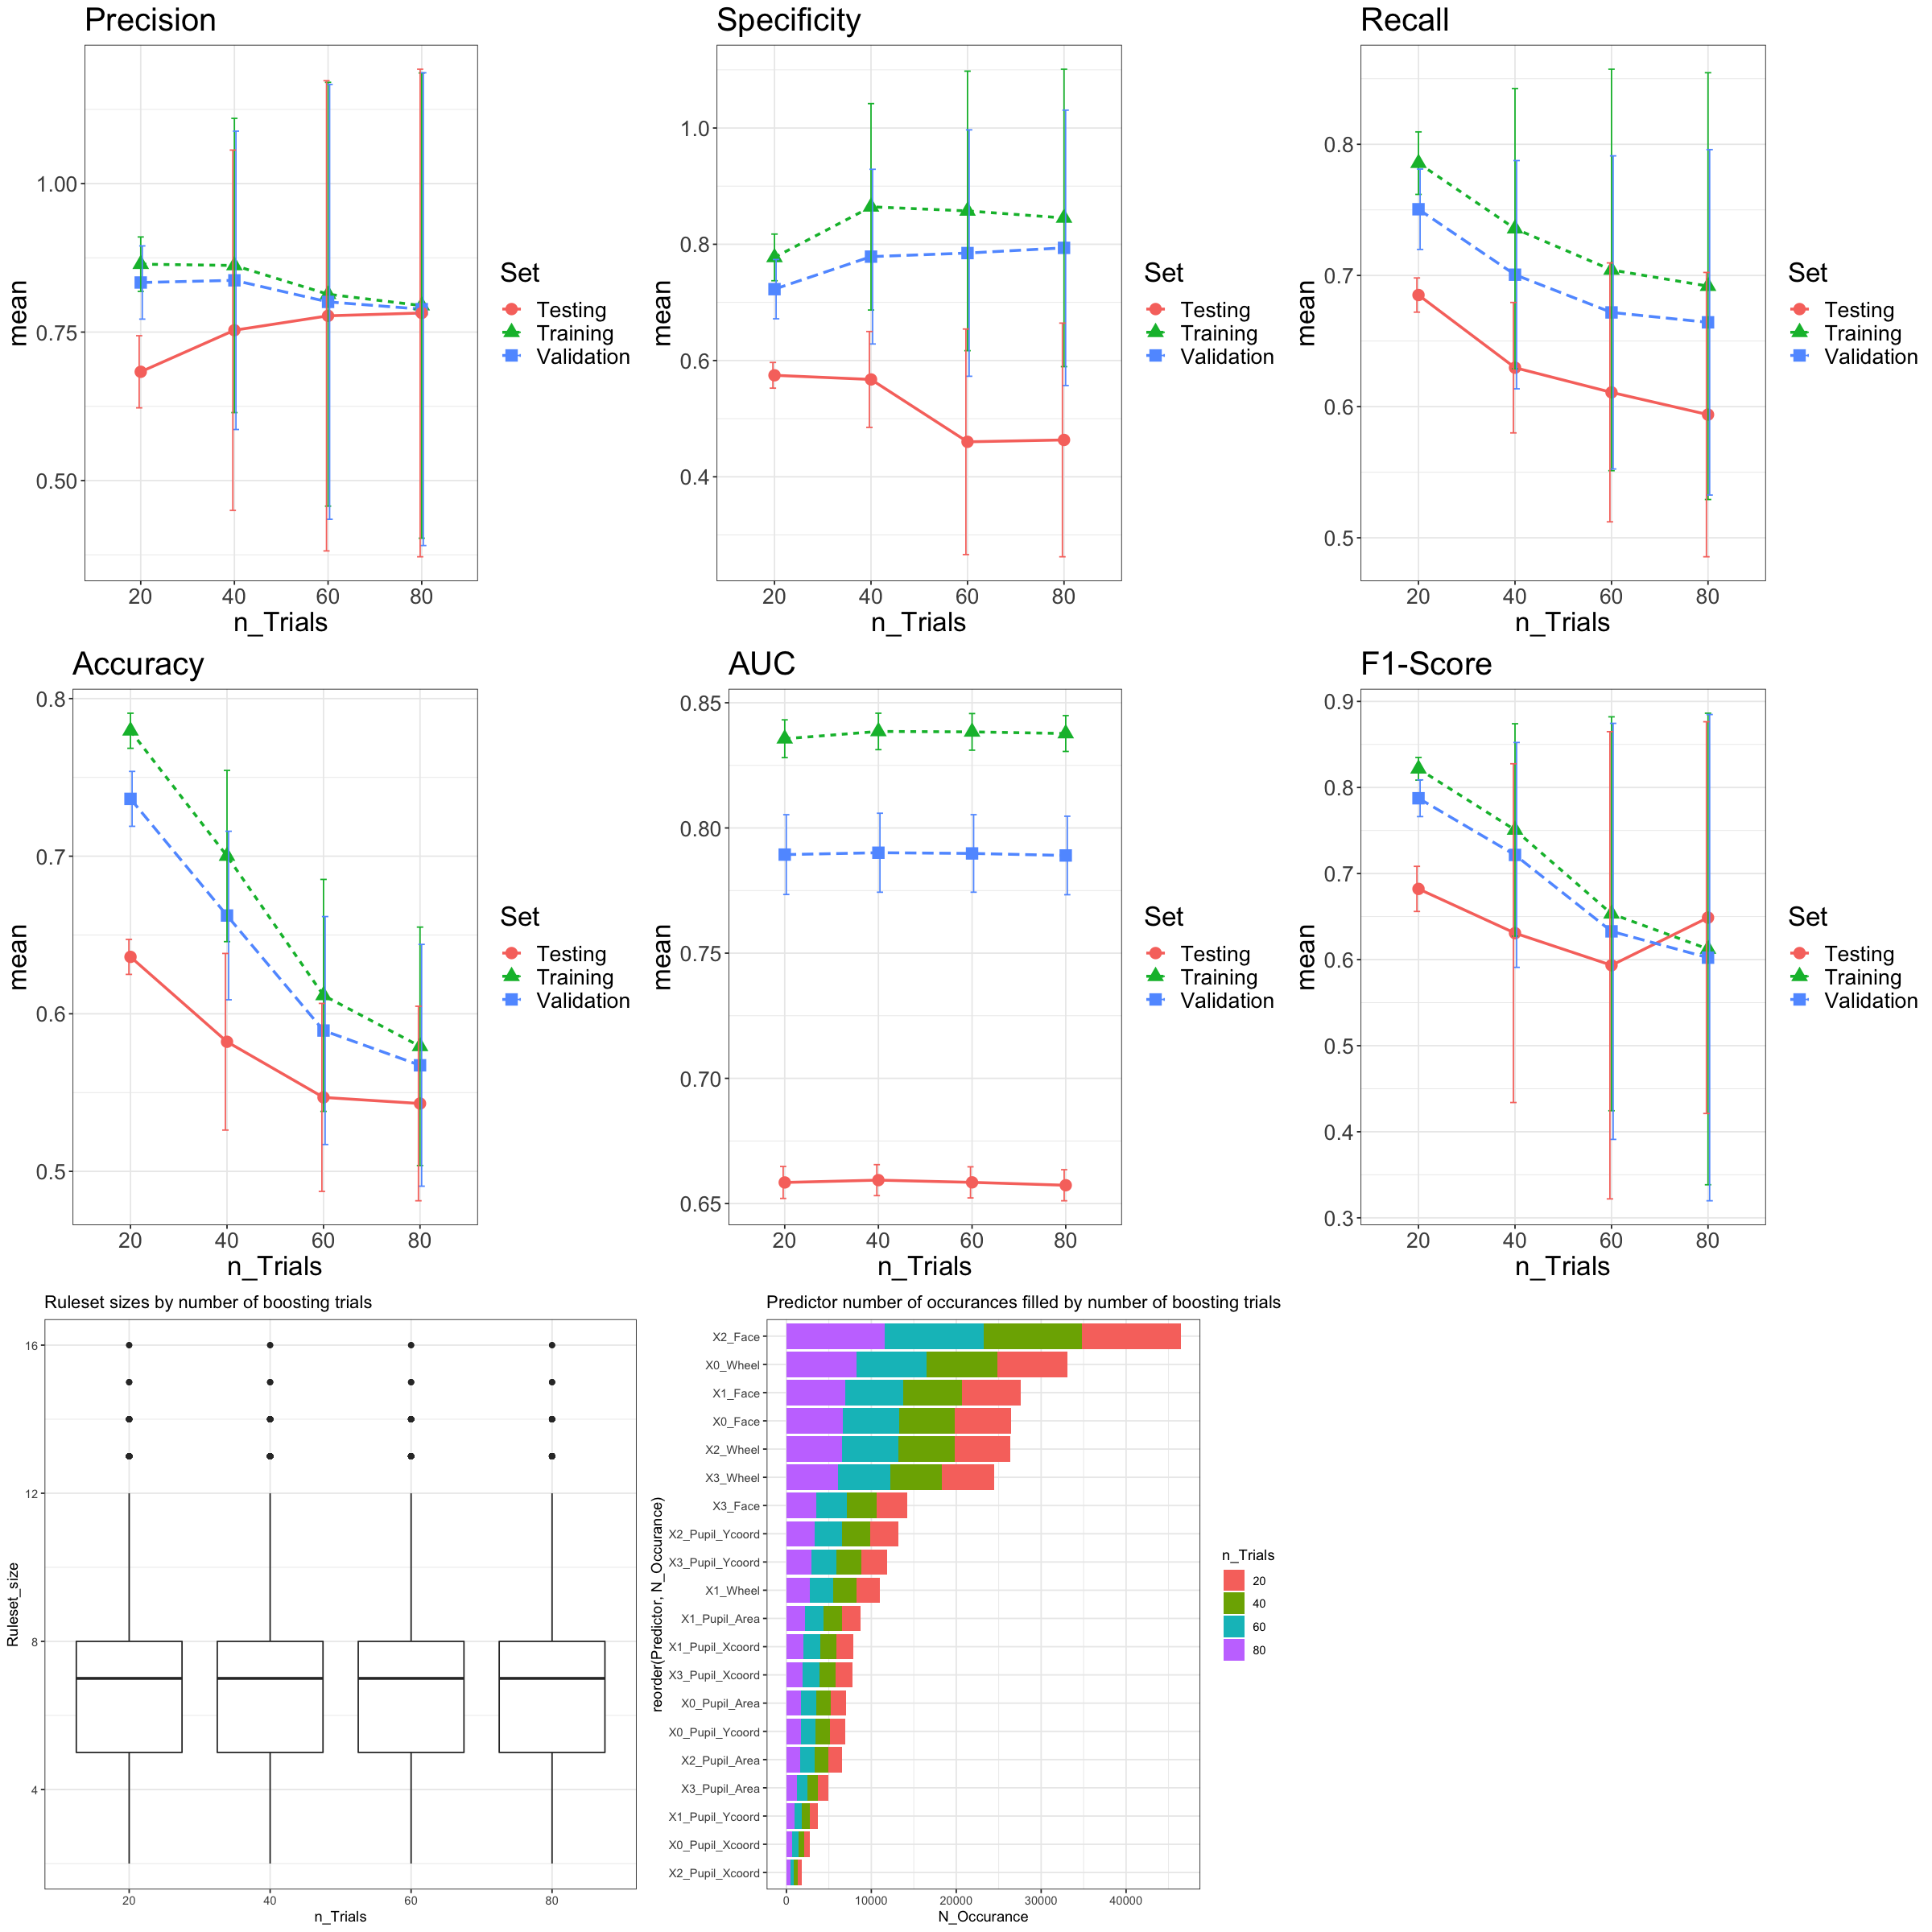

In [303]:
plot_metrics(res_mcar)

In [311]:
print('Precision')
res_mcar$precision
print('Specificity')
res_mcar$specificity
print('Recall')
res_mcar$recall
print('Accuracy')
res_mcar$acc
print('AUC')
res_mcar$auc
print('F1-Score')
res_mcar$f1
print('Scores for n_Trials = best')
tab <- bind_rows(res_mcar$precision[which(res_mcar$n_Trials == res_mcar$best),], 
                 res_mcar$recall[which(res_mcar$n_Trials == res_mcar$best),], 
                 res_mcar$specificity[which(res_mcar$n_Trials == res_mcar$best),], 
                 res_mcar$acc[which(res_mcar$n_Trials == res_mcar$best),], 
                 res_mcar$auc[which(res_mcar$n_Trials == res_mcar$best),], 
                 res_mcar$f1[which(res_mcar$n_Trials == res_mcar$best),])
rownames(tab) <- c("Precision", "Recall", "Specificity", "Accuracy", "AUC", "F1-Score")
tab
print('Predictor Occurances in Rulesets')
res_mcar$predictor_usage

[1] "Precision"


,Training_mean,Training_sd,Validation_mean,Validation_sd,Testing_mean,Testing_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.8643465,0.04582524,0.8334706,0.06163175,0.6831602,0.06071148
40,0.8621661,0.24770809,0.8371426,0.25115951,0.7531323,0.30331669
60,0.8137352,0.35676875,0.8008572,0.36604121,0.7774204,0.39584594
80,0.7946049,0.39163559,0.7886000,0.39795561,0.7821441,0.41044132


[1] "Specificity"


,Training_mean,Training_sd,Validation_mean,Validation_sd,Testing_mean,Testing_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.7774171,0.04013001,0.7227881,0.05099381,0.5745936,0.02209794
40,0.8644339,0.17755334,0.7787488,0.15028566,0.5674521,0.08247208
60,0.8573781,0.24043438,0.7848820,0.21195642,0.4601636,0.19402000
80,0.8453056,0.25585071,0.7938210,0.23688548,0.4633807,0.20099574


[1] "Recall"


,Training_mean,Training_sd,Validation_mean,Validation_sd,Testing_mean,Testing_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.7856346,0.0238302,0.7504838,0.03063395,0.6850798,0.01304246
40,0.7356817,0.1068062,0.7005899,0.08700509,0.6296952,0.04972048
60,0.7042094,0.1530370,0.6718248,0.11935858,0.6108723,0.09870068
80,0.6918744,0.1626979,0.6642758,0.13169151,0.5939204,0.10838891


[1] "Accuracy"


,Training_mean,Training_sd,Validation_mean,Validation_sd,Testing_mean,Testing_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.7795922,0.01113157,0.7363801,0.01741672,0.6361047,0.01110325
40,0.7001106,0.05433384,0.6623487,0.05347096,0.5822415,0.05604563
60,0.6116576,0.07360037,0.5893726,0.07232100,0.5469461,0.05964437
80,0.5793553,0.07565292,0.5673159,0.07671722,0.5430636,0.06172096


[1] "AUC"


,Training_mean,Training_sd,Validation_mean,Validation_sd,Testing_mean,Testing_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.8356324,0.007547143,0.7893617,0.01593068,0.6584211,0.006377805
40,0.8385511,0.007273447,0.7901115,0.01577312,0.6593502,0.006188677
60,0.8383760,0.007315054,0.7898248,0.01547926,0.6584604,0.006211251
80,0.8377103,0.007158467,0.7890100,0.01567735,0.6573095,0.006206816


[1] "F1-Score"


,Training_mean,Training_sd,Validation_mean,Validation_sd,Testing_mean,Testing_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.8217418,0.01318042,0.7874982,0.02131965,0.6821659,0.02621799
40,0.7506741,0.12338556,0.7216423,0.13063939,0.6307786,0.19678641
60,0.6532582,0.22883354,0.6328407,0.24169251,0.5934376,0.27141966
80,0.6123573,0.27393009,0.6022950,0.28247229,0.6488088,0.22757172


[1] "Scores for n_Trials = best"


,Training_mean,Training_sd,Validation_mean,Validation_sd,Testing_mean,Testing_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Precision,0.8643465,0.045825236,0.8334706,0.06163175,0.6831602,0.060711479
Recall,0.7856346,0.023830198,0.7504838,0.03063395,0.6850798,0.013042460
Specificity,0.7774171,0.040130011,0.7227881,0.05099381,0.5745936,0.022097943
Accuracy,0.7795922,0.011131572,0.7363801,0.01741672,0.6361047,0.011103247
AUC,0.8356324,0.007547143,0.7893617,0.01593068,0.6584211,0.006377805
F1-Score,0.8217418,0.013180415,0.7874982,0.02131965,0.6821659,0.026217989


[1] "Predictor Occurances in Rulesets"


,X0_Wheel,X1_Wheel,X2_Wheel,X3_Wheel,X0_Face,X1_Face,X2_Face,X3_Face,X0_Pupil_Area,X1_Pupil_Area,X2_Pupil_Area,X3_Pupil_Area,X0_Pupil_Xcoord,X1_Pupil_Xcoord,X2_Pupil_Xcoord,X3_Pupil_Xcoord,X0_Pupil_Ycoord,X1_Pupil_Ycoord,X2_Pupil_Ycoord,X3_Pupil_Ycoord
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,8267,2760,6595,6111,6619,6900,11605,3548,1749,2171,1647,1233,694,1973,454,1934,1722,924,3291,2954
40,8267,2760,6595,6111,6619,6900,11605,3548,1749,2171,1647,1233,694,1973,454,1934,1722,924,3291,2954
60,8267,2760,6595,6111,6619,6900,11605,3548,1749,2171,1647,1233,694,1973,454,1934,1722,924,3291,2954
80,8267,2760,6595,6111,6619,6900,11605,3548,1749,2171,1647,1233,694,1973,454,1934,1722,924,3291,2954


In [270]:
# 10-fold CV for 30 iterations using the original dataset and the best value for n_Trials from the tuning 
# step with the MCAR dataset with respect to validation accuracy
res <- cross_validate_C50(data_train = data_train,
                         data_test = data_test,
                         ycol = 21,
                         window_sizes = res_mcar$best,
                         k_folds = k_folds,
                         n_iter = n_iter,
                         start_seed = start_seed)

[1] "======================================================================================="
[1] "======================================================================================="
[1] "Trials: 20"
[1] "======================================================================================="
[1] "======================================================================================="
[1] "================================================================"
[1] "Iteration: 1"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 2"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 3"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 4"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 5"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 6"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 7"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 8"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 9"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 10"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 11"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 12"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 13"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 14"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 15"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 16"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 17"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 18"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 19"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 20"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 21"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 22"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 23"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 24"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 25"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 26"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 27"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 28"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 29"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "================================================================"
[1] "Iteration: 30"
[1] "================================================================"
[1] "----------------------------"
[1] "Fold: 1"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 2"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 3"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 4"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 5"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 6"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 7"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 8"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 9"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "----------------------------"
[1] "Fold: 10"
[1] "----------------------------"


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



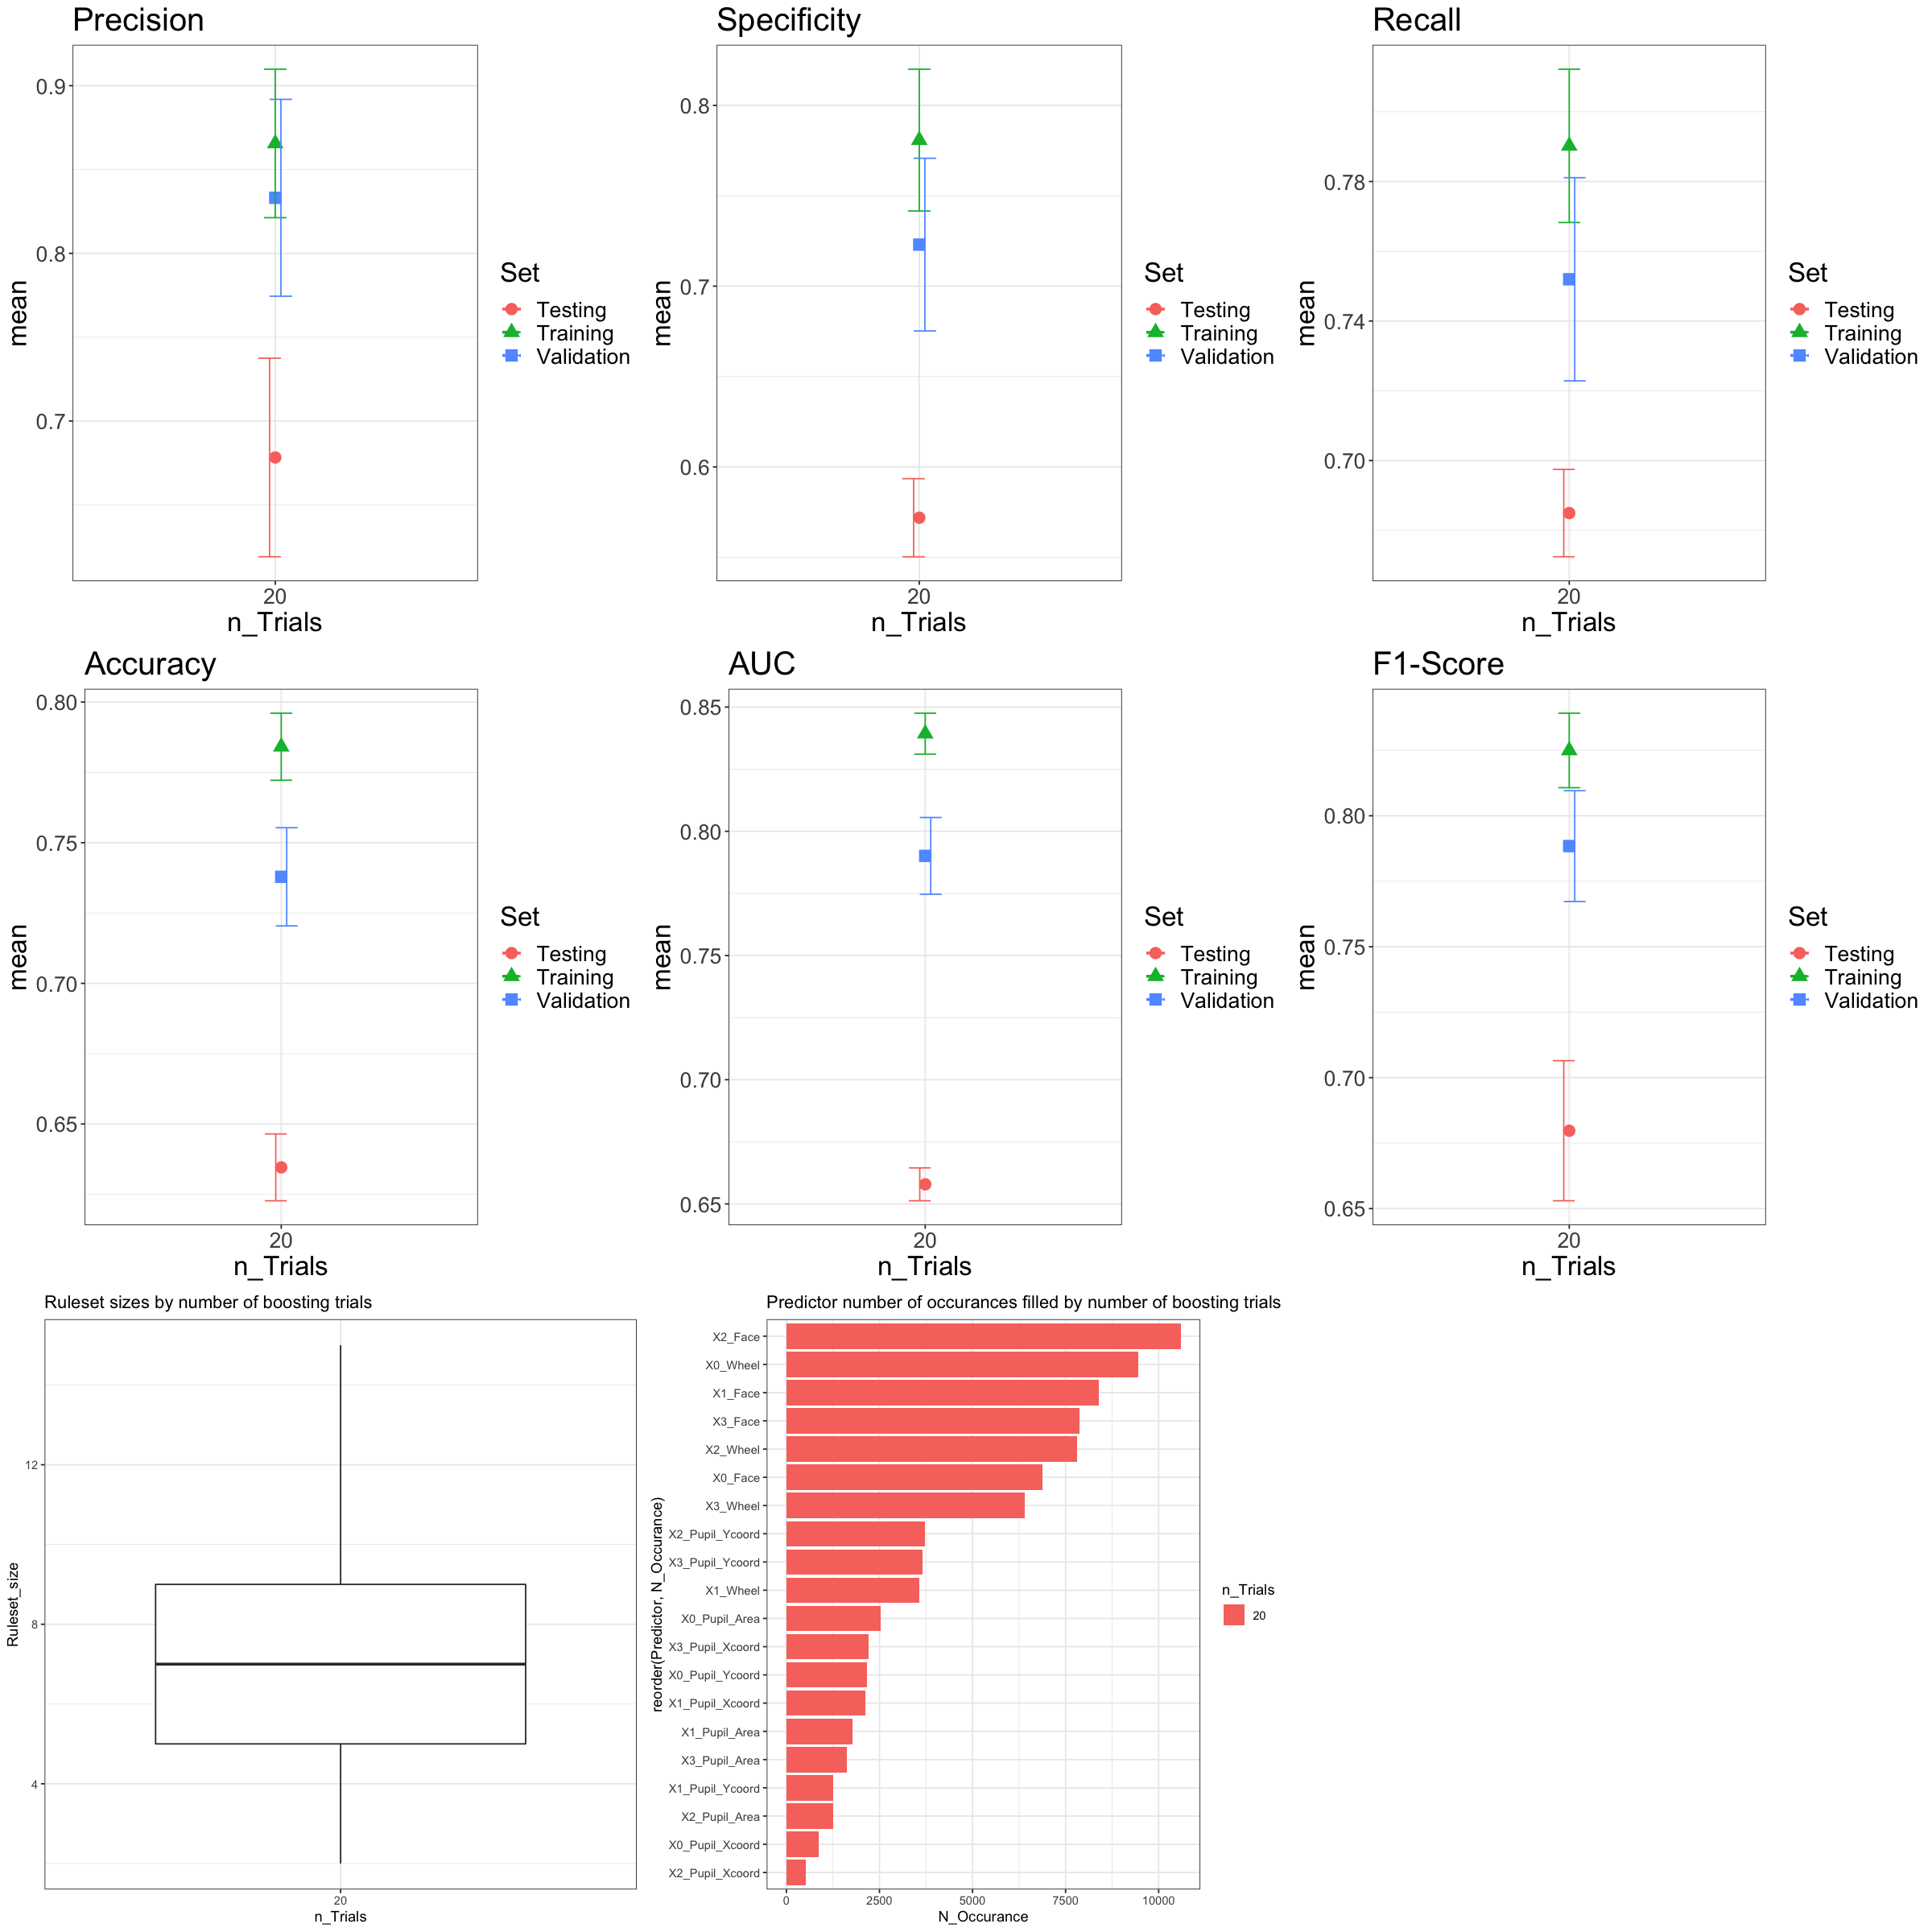

In [304]:
plot_metrics(res)

In [306]:
tab <- bind_rows(res$precision, res$recall, res$specificity, res$acc, res$auc, res$f1)
rownames(tab) <- c("Precision", "Recall", "Specificity", "Accuracy", "AUC", "F1-Score")
tab
res$predictor_usage

,Training_mean,Training_sd,Validation_mean,Validation_sd,Testing_mean,Testing_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Precision,0.8655629,0.044276031,0.8331470,0.05870835,0.6782691,0.059239607
Recall,0.7902184,0.021972805,0.7519705,0.02912583,0.6849358,0.012524511
Specificity,0.7807711,0.039223156,0.7229726,0.04775849,0.5718947,0.021594433
Accuracy,0.7841220,0.011915468,0.7378730,0.01745421,0.6345793,0.011881114
AUC,0.8393028,0.008230976,0.7901084,0.01544979,0.6578815,0.006619025
F1-Score,0.8249514,0.014220694,0.7884359,0.02115601,0.6797293,0.026746076


,X0_Wheel,X1_Wheel,X2_Wheel,X3_Wheel,X0_Face,X1_Face,X2_Face,X3_Face,X0_Pupil_Area,X1_Pupil_Area,X2_Pupil_Area,X3_Pupil_Area,X0_Pupil_Xcoord,X1_Pupil_Xcoord,X2_Pupil_Xcoord,X3_Pupil_Xcoord,X0_Pupil_Ycoord,X1_Pupil_Ycoord,X2_Pupil_Ycoord,X3_Pupil_Ycoord
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,9454,3563,7811,6396,6882,8401,10590,7871,2536,1784,1250,1627,857,2130,520,2203,2155,1261,3731,3665
